# Measure the speed of the Markdown package across recent versions

The current version of the Markdown package for TeX takes multiple seconds to initialize and process a markdown text:

In [1]:
! docker run --rm -i witiko/markdown bash -c 'time markdown-cli' <<< foo

\markdownRendererDocumentBegin
foo\markdownRendererDocumentEnd

real	0m1.565s
user	0m1.347s
sys	0m0.213s


This Jupyter notebook measures the speed of historic versions of the Markdown package for TeX and compares them with the current version of the Markdown package.

### Experiment

In my experiment, I time the command `markdown-cli <<< foo` with the Docker images for all versions of the Markdown package since version 2.23.0 on my Dell G5 15 notebook.

In [2]:
from packaging.version import Version

In [3]:
tags = ! git tag | grep -E '2.23.0|^3'
tags = sorted(tags, key=Version)
print(', '.join(tags))

2.23.0, 3.0.0-alpha, 3.0.0-alpha.2, 3.0.0, 3.0.1, 3.1.0, 3.2.0, 3.2.1, 3.3.0, 3.4.0, 3.4.1, 3.4.2, 3.4.3, 3.5.0, 3.6.0, 3.6.1, 3.6.2


To determine the median and confidence intervals, I repeat the test five times for every tag.

In [4]:
%%capture
! pip install tqdm

In [5]:
from collections import defaultdict
from itertools import product

from tqdm import tqdm

In [6]:
durations_all = defaultdict(lambda: list())
parameters = list(product(range(5), tags))
for repetition, tag in tqdm(parameters, ncols=50):
    abbrev = 8 if Version(tag) >= Version('3.2.0') else 7
    lines = ! docker run --rm -i witiko/markdown:`git describe --abbrev=$abbrev --tags --always --long --exclude latest $tag`-latest bash -c 'time markdown-cli <<< foo'
    for line in lines:
        if line.startswith('real'):
            _, duration = line.split()
            assert len(durations_all[tag]) == repetition
            durations_all[tag].append(duration)
            break
    else:
        raise ValueError(f'Unexpected output for tag {tag}: {lines}')

100%|█████████████| 85/85 [01:17<00:00,  1.10it/s]


## Results
In this section, I discuss the results of the experiment.

In [7]:
import re

In [8]:
durations_seconds_all = dict()
for tag, durations in durations_all.items():
    durations_seconds = list()
    for duration in durations:
        match = re.match(r'(?P<minutes>[0-9]+)m(?P<seconds>[0-9.]+)s', duration)
        assert match
        duration_seconds = int(match.group('minutes')) + float(match.group('seconds'))
        durations_seconds.append(duration_seconds)
    durations_seconds_all[tag] = durations_seconds
    assert len(durations_seconds_all[tag]) == len(durations_all[tag])
assert len(durations_seconds_all) == len(durations_all)

In [9]:
from statistics import median

In [10]:
durations_seconds_median = {
    tag: median(durations)
    for tag, durations
    in durations_seconds_all.items()
}

Below, I show the median processing times for all considered versions of the Markdown package.

In [11]:
%%capture
! pip install matplotlib

In [12]:
import matplotlib.pyplot as plt

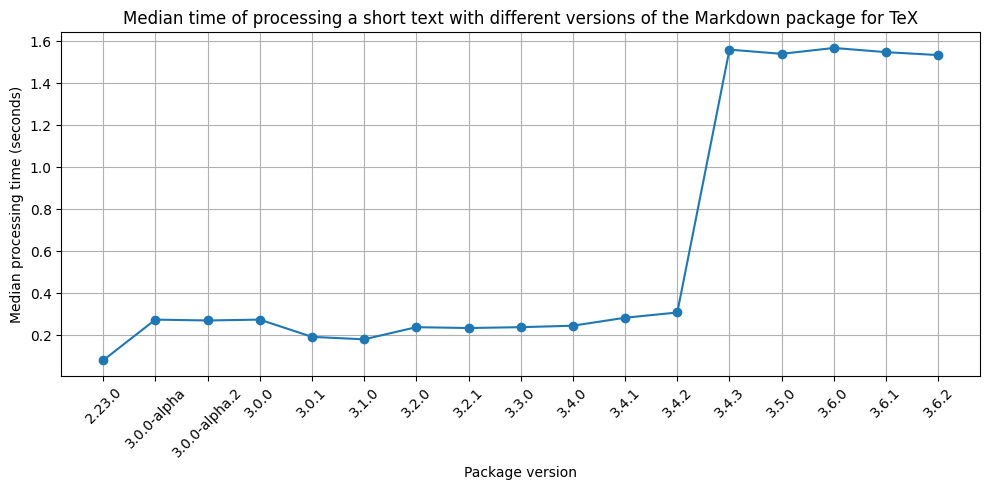

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*durations_seconds_median.items()), marker='o', linestyle='-')
plt.title('Median time of processing a short text with different versions of the Markdown package for TeX')
plt.xlabel('Package version')
plt.ylabel('Median processing time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

The results show a more than 5× slow-down in [version 3.4.3][1] of the Markdown package for TeX.

 [1]: https://github.com/Witiko/markdown/releases/tag/3.4.3